In [2]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
tf.config.run_functions_eagerly(True)

2022-05-16 14:18:21.982250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 14:18:21.982299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [4]:
entanglementInitState = [0, 1]
entanglementInitStateFull = [0, 1]

def printSignal(exper: Experiment, qubits: List[chip.Qubit],
                gate: gates.Instruction, output: DataOutput,
                states: List[Tuple[float, str]] = None):
    signals = exper.pmap.generator.generate_signals(gate)
    for i, qubit in enumerate(qubits):
        # generate signal
        drive = getDrive(exper.pmap.model, qubit).name
        signal = signals[drive]
        ts = signal["ts"].numpy()
        values = signal["values"].numpy()

        # save data
        peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
        print(f"peaks: {drive}", np.sort(peakFrequencies))
        output.save([ts, values], f"signal_t{i + 1}")

        # plot
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_t{i + 1}", "svg"),
                              spectralThreshold=None)
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_{i + 1}", "svg"),
                              spectralThreshold=4e-5)
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_with_states_{i + 1}", "svg"),
                              states=states,
                              spectralThreshold=4e-5)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population", "svg"))
    plotSplittedPopulation(exper, populations, [gate.get_key()], filename=output.createFileName("population", "svg"))


def stateEntropyAB(state: tf.Tensor):
    rho = densityMatrix(state)
    #rho = tf_project_to_comp(rho, dims=[5] * 2, outdims=[4] * 2)
    rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)


def printEntanglementEvolution(exper: Experiment, gate: gates.Instruction, output: DataOutput):
    entropies = []
    #for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
    for state in [(0, 1), (0, 4), (1, 5), (4, 5)]:
    #for state in [(0, 4), (5, 6), (10, 11), (12, 13)]:
        psi_init = np.zeros(shape=(model.tot_dim,))
        psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
        entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropyAB)
        entropies.append(entropy)
    entropies = np.array(entropies)
    plotPopulation(exper, entropies, sequence=[gate.get_key()],
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name, "svg"), colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    #output.save(exper.partial_propagators[gate.get_key()], "partial_propagators")
    #os.system('bzip2 -9 "' + output.createFileName('partial_propagators.npy') + '"')
    printMatrix(U, labels, "propagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)

'''
def entanglementStateGoal(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )
    entropies = []
    for state in [(0, 4)]: #, (0, 1), (1, 5), (4, 5)]:
        psi_init = [[0] * dim]
        psi_init[0][state[0]] = psi_init[0][state[1]] = 1.0 / np.sqrt(2)
        init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        #psi = np.zeros((dim, 1))
        #psi[state[0], 0] = psi[state[1], 0] = 1 / np.sqrt(2)
        #psi_init = tf.constant(psi, dtype=actual_comp.dtype)
        #init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
        psi_actual = tf.matmul(actual_comp, init_state)
        rho = densityMatrix(psi_actual)

        # S(B) - S(BD)
        rhoBD = partialTrace(rho, [1, 3])
        #entropyBD = entanglementEntropy(rhoBD)
        rhoB = partialTrace(rhoBD, [0])
        entropyB = entanglementEntropy(rhoB)
        entropies.append(entropyB)

        # S(AB)
        #rhoAB = partialTrace(rho, [0, 1])
        #entropies.append(entanglementEntropy(rhoAB) / 2)
    return 1 - np.max(entropies)
'''

def entanglementStateGoalTF(actual: tf.constant, index, dims, active_levels):
    dim = active_levels ** len(dims)
    actual_comp = tf_project_to_comp(
        actual, dims=dims, index=index, outdims=[active_levels] * len(dims)
    )

    # initial and final state
    psi = np.zeros((dim, 1))
    for i in entanglementInitState:
        psi[i, 0] = 1
    psi /= np.linalg.norm(psi)
    psi_init = tf.constant(psi, dtype=actual_comp.dtype)
    psi_actual = tf.matmul(actual_comp, psi_init)
    rho = densityMatrixTF(psi_actual[:, 0])

    # calculate entropy
    rhoBD = partialTraceTF(rho, [1, 3])
    entropyBD = entanglementEntropyTF(rhoBD) / 2
    rhoB = partialTraceTF(rhoBD, [0])
    entropyB = entanglementEntropyTF(rhoB)
    return (1.0 - entropyB + entropyBD) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))

    #rhoAB = partialTraceTF(rho, [0, 1])
    #entropyAB = entanglementEntropyTF(rhoAB)
    #return (2.0 - entropyAB) + 0.5 * (1.0 - tf.math.real(tf.norm(psi_actual)))


def entanglementGoal(propagators: dict, instructions: dict, index, dims, active_levels=2, n_eval=-1):
    infids = []
    for gate, propagator in propagators.items():
        infid = entanglementStateGoalTF(propagator, index, dims, active_levels)
        infids.append(infid)
    return tf.reduce_mean(infids)


def optimise(output: DataOutput, qubits: List[chip.PhysicalComponent],
             exp: Experiment, algorithm, options, gate: gates.Instruction):
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        #fid_func=entanglementGoal,
        fid_subspace=[q.name for q in qubits],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []

    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)

    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [10]:
# Initialise the qubits and drive lines
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]
couplingStrength = 30e6

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]
output = DataOutput(output_dir, file_suffix='before')

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

['|0,0\\rangle', '|0,1\\rangle', '|1,0\\rangle', '|1,1\\rangle', 'leakage', 'leakage', 'leakage']


In [5]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::5]
qubitEnergies[1] = qubitEnergies[1][:5]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
[5.0e+09 4.7e+09 4.4e+09 4.1e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10 1.650e+10]
[4.50e+09 4.25e+09 4.00e+09 3.75e+09]


In [6]:
#stored_pmap = PMap()
#stored_pmap.read_config("./optimised_params/1transmon/X_q2_200ns.json")
#stored_params = stored_pmap.asdict()["X_q2[0]"]

/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate:  . Use set_ideal() explicitly.
  warnings.warn(
/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate: X_t1q2. Use set_ideal() explicitly.
  warnings.warn(


In [7]:
# Create the generator
generator = createGenerator2LOs(drives, useDrag=False, usePWC=True)

In [8]:
# Envelopes and carriers
t_final = 200e-9

carrier_freqs = [
    #[0.5*(qubitTransitions[0][1]+qubitTransitions[0][0]), 0.5*(qubitTransitions[0][2]+qubitTransitions[0][1])],
    [qubitTransitions[0][0], qubitTransitions[0][2]],
    #[qubitTransitions[1][0]],
    #[0.5*(qubitTransitions[1][1]+qubitTransitions[1][0]), 0.5*(qubitTransitions[1][2]+qubitTransitions[1][1])],
    [qubitTransitions[1][0], qubitTransitions[1][2]]
    #[qubitTransitions[1][0]]
]
df = couplingStrength ** 2 / (qubit_frequencies[0] - qubit_frequencies[1])
print("shift: ", df)
carrier_freqs[0] = [x + df for x in carrier_freqs[0]]
carrier_freqs[1] = [x - df for x in carrier_freqs[1]]

carrier_framechange = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_t_final = [
    [t_final, t_final],
    [t_final, t_final]
]
pulse_sigmas = [
    [t_final/5, t_final/5],
    [t_final/5, t_final/5]
]
pulse_amps = [
    [0.05, 0.05],
    [0.05, 0.05]
]
pulse_deltas = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_xy_angles = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_freq_offsets = [
    [0.01, 0.01],
    [0.01, 0.01]
]

envelopes = []
envelopesForDrive = {d.name: [] for d in drives}
carriers = []
carriersForDrive = {d.name: [] for d in drives}

numPWCPieces = 30
usePWC = True


'''
for idx in [1]:
    dstIdx = idx
    srcIdx = 0 #1 - idx
    driveNameSrc = drives[srcIdx].name
    driveNameDst = drives[dstIdx].name
    stored_params_d = stored_params["drive_channels"][driveNameSrc]
    for i in range(0, len(carrier_freqs[idx])):
        env: pulse.Envelope = stored_params_d[f"envelope_{driveNameSrc}_{i + 1}"]
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{driveNameDst}_{i + 1}"
        #env.params['amp'] = scaleQuantity(env.params['amp'], 10)
        #env.params['sigma'] = scaleQuantity(env.params['sigma'], 2)
        env = scaleGaussianEnvelope(env, t_final / env.params['t_final'].get_value())
        envelopes.append(env)
        envelopesForDrive[driveNameDst].append(env)

        shift = df # if dstIdx == 0 else -df
        carrier = stored_params_d[f"carrier_{driveNameSrc}_{i + 1}"]
        carrier.params["freq"].set_value(
            carrier.params["freq"].get_value() / (2 * np.pi) + shift
        )
        #carrier.params["freq"] = Qty(
        #    value=carrier_freqs[dstIdx][i],
        #    min_val=0.95 * carrier_freqs[dstIdx][i],
        #    max_val=1.05 * carrier_freqs[dstIdx][i],
        #    unit="Hz 2pi"
        #)
        carrier.name = f"carrier_{driveNameDst}_{i + 1}"
        carriers.append(carrier)
        carriersForDrive[driveNameDst].append(carrier)
'''
'''
for idx in [0, 1]:
    driveName = drives[0].name
    driveNameTarget = drives[idx].name
    stored_params_d = stored_params["drive_channels"][driveName]
    for i in range(0, len(carrier_freqs[0])):
        env = copy.deepcopy(stored_params_d[f"envelope_{driveName}_{i + 1}"])
        env.params["amp"] = Quantity(value=pulse_amps[idx][i], min_val=0.5 * pulse_amps[idx][i],
                                     max_val=1.5 * pulse_amps[idx][i], unit="V")
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{driveNameTarget}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[driveNameTarget].append(env)
        carrier = copy.deepcopy(stored_params_d[f"carrier_{driveName}_{i + 1}"])
        carrier.name = f"carrier_{driveNameTarget}_{i + 1}"
        carriers.append(carrier)
        carriersForDrive[driveNameTarget].append(carrier)
'''
for idx in [0, 1]:
    for i in range(0, len(carrier_freqs[idx])):
        env = createGaussianPulse(
            t_final=pulse_t_final[idx][i],
            sigma=pulse_sigmas[idx][i],
            amp=pulse_amps[idx][i],
            delta=pulse_deltas[idx][i],
            xy_angle=pulse_xy_angles[idx][i],
            freq_off=pulse_freq_offsets[idx][i]
        )
        #env = createNoDriveEnvelope(t_final)
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{drives[idx].name}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[drives[idx].name].append(env)

        carrier_parameters = {
            "freq": Qty(value=carrier_freqs[idx][i], min_val=0.98 * carrier_freqs[idx][i],
                        max_val=1.02 * carrier_freqs[idx][i], unit="Hz 2pi"),
            "framechange": Qty(value=carrier_framechange[idx][i], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
        }
        carrier = pulse.Carrier(
            name=f"carrier_{drives[idx].name}_{i + 1}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        )
        carriers.append(carrier)
        carriersForDrive[drives[idx].name].append(carrier)

print("carrier: ", [[carrier.params["freq"] for carrier in carriers] for carriers in carriersForDrive.values()])
print("amp: ", [[env.params["amp"] for env in envelopes] for envelopes in envelopesForDrive.values()])

shift:  0.0
carrier:  [[5.000 GHz 2pi, 4.400 GHz 2pi], [4.500 GHz 2pi, 4.000 GHz 2pi]]
amp:  [[10.000 µV, 10.000 µV], [61.092 mV, 33.868 mV]]


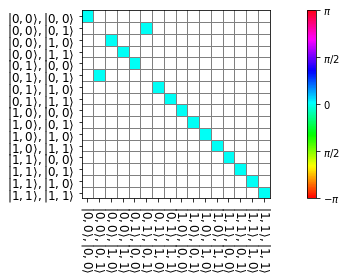

/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate: CNOT_t2q2_t1q2_fixed00. Use set_ideal() explicitly.
  warnings.warn(


In [9]:
# Gate instructions
#ideal_gate_X2 = qt_utils.np_kron_n([constants.x90p, constants.Id])
#ideal_gate_Unity = qt_utils.np_kron_n([constants.Id, constants.Id])
#ideal_gate = gates.GATES["cx"]
#ideal_gate = np.array(
#    [[1, 0, 0, 0], [0, 0, 0, 1j], [0, 0, 1, 0], [0, 1j, 0, 0]], dtype=np.complex128
#)
#ideal_gate = custom_gates.GATE_iCNOT_t2q2_t1q2_fixed00
ideal_gate = np.eye(model.tot_dim)
#ideal_gate = constants.GATES["cx"]
#ideal_gate_single = qt_utils.np_kron_n([constants.Id, constants.GATES["rx90p"]])
#ideal_gate = qt_utils.np_kron_n([ideal_gate_single, ideal_gate_Unity])
#ideal_gate = scipy.linalg.block_diag([ideal1, ideal_gate_Unity])
#printMatrix(ideal_gate, level_labels, "ideal_gate", output)
printMatrix(ideal_gate, level_labels, "ideal_gate", output)

gate = gates.Instruction(
    #name="CNOT_t2q2_t1q2_fixed00" + ("_pwc" if usePWC else ""),
    name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final,
    channels=[d.name for d in drives],
    ideal=ideal_gate,
)
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        gate.add_component(copy.deepcopy(env), drive.name)
    for carrier in carriersForDrive[drive.name]:
        gate.add_component(copy.deepcopy(carrier), drive.name)

In [10]:
# all energy levels with labels
stateEnergies = []
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)
indices = [np.argmax(np.round(evecs[i], 2)) for i in range(len(evals))]
for i, x in enumerate(level_labels_short):
    if level_labels_short[i] is not None:
        energy = evals[indices[i]]
        stateEnergies.append((energy, x))

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

#for t in transitions:
#    print(t)

In [11]:

'''
from c3.utils.qt_utils import np_kron_n


def projector(dims, indices, outdims=None):
    ids = []
    print("dims: ", dims)
    for index, dim in enumerate(dims):
        outdim = outdims[index]
        print(index, "outdim: ", outdim)
        if index in indices and outdim > 0:
            ids.append(np.eye(dim, outdim))
        else:
            ids.append(np.eye(dim, 1))
        print(ids)
    return np_kron_n(ids)

def project(A, dims, index=None, outdims=None):
    proj = projector(dims, index, outdims=outdims)
    P = tf.constant(proj, dtype=A.dtype)
    return tf.matmul(tf.matmul(P, A, transpose_a=True), P)

print(ideal_gate.shape)
idealProj = project(ideal_gate, dims=[2, 2, 2, 2], index=[0, 1, 2, 3], outdims=[0, 2, 0, 2])
print(idealProj)
'''

'\nfrom c3.utils.qt_utils import np_kron_n\n\n\ndef projector(dims, indices, outdims=None):\n    ids = []\n    print("dims: ", dims)\n    for index, dim in enumerate(dims):\n        outdim = outdims[index]\n        print(index, "outdim: ", outdim)\n        if index in indices and outdim > 0:\n            ids.append(np.eye(dim, outdim))\n        else:\n            ids.append(np.eye(dim, 1))\n        print(ids)\n    return np_kron_n(ids)\n\ndef project(A, dims, index=None, outdims=None):\n    proj = projector(dims, index, outdims=outdims)\n    P = tf.constant(proj, dtype=A.dtype)\n    return tf.matmul(tf.matmul(P, A, transpose_a=True), P)\n\nprint(ideal_gate.shape)\nidealProj = project(ideal_gate, dims=[2, 2, 2, 2], index=[0, 1, 2, 3], outdims=[0, 2, 0, 2])\nprint(idealProj)\n'

peaks:  [2.39505988e+09 2.40506013e+09 4.40011000e+09 6.40516013e+09]


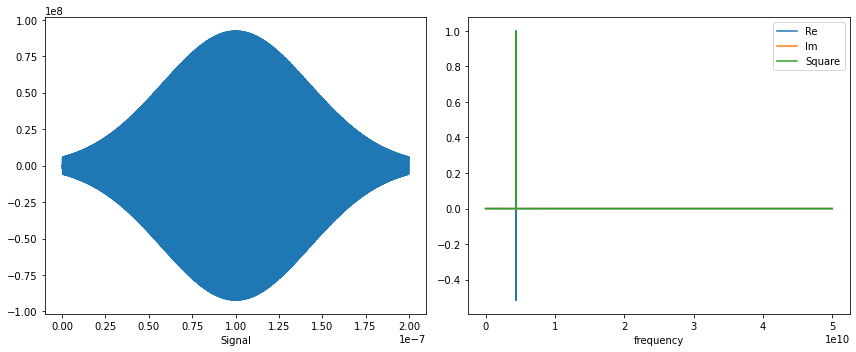

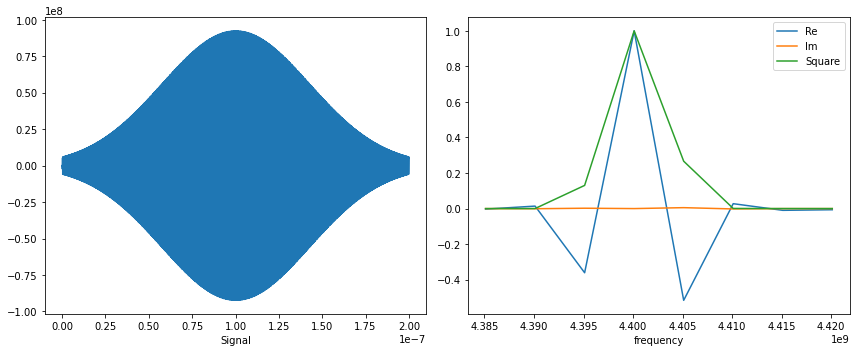

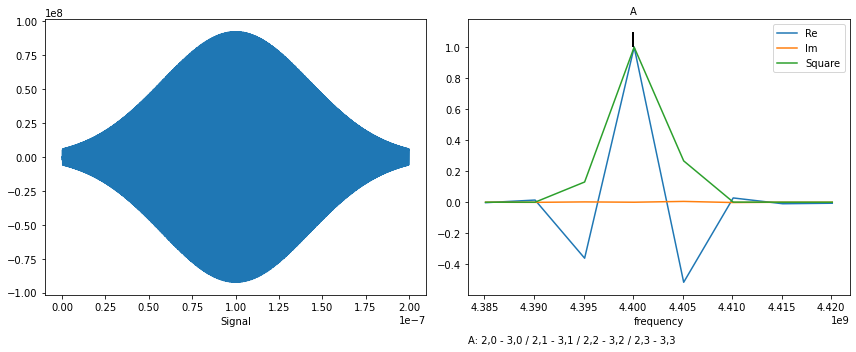

peaks:  [2.39505988e+09 2.40506013e+09 4.40011000e+09 6.40516013e+09]


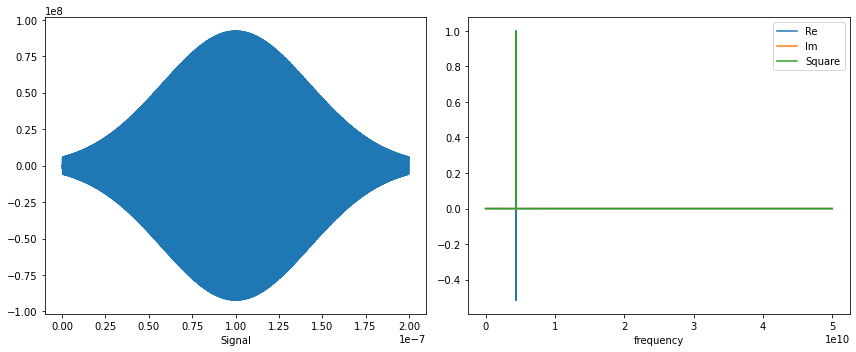

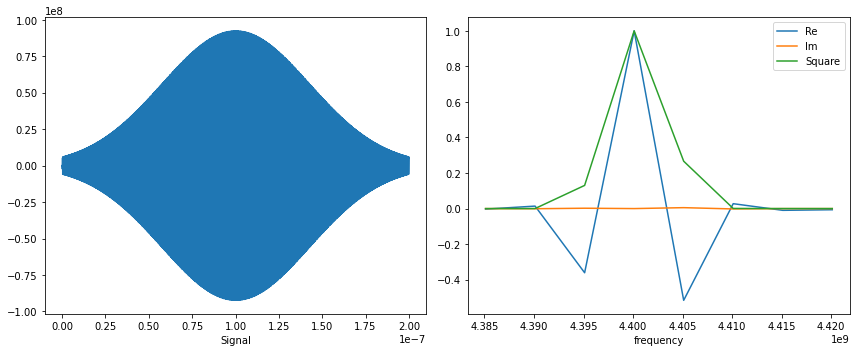

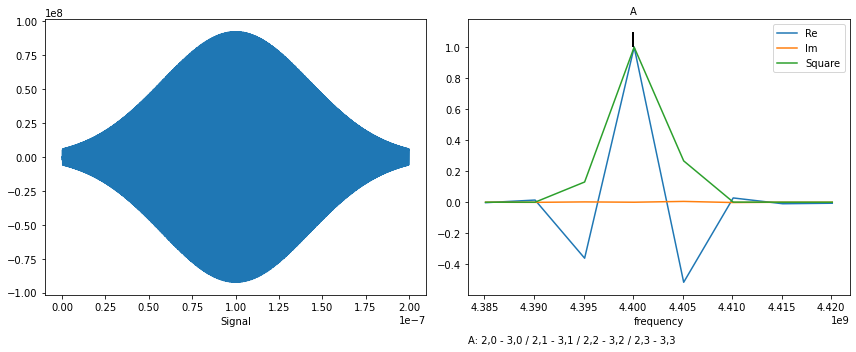

2022-05-16 11:01:12.768769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


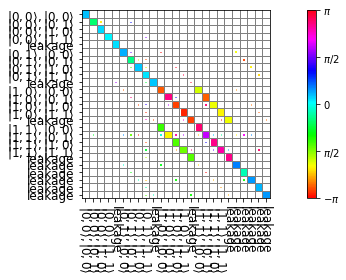

In [12]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([gate.get_key()])

printSignal(exp, qubits, gate, output=output, states=transitions)

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels_with_leakage, output)
#printAllSignals(exp, qubit, output, directory="devices_before")

In [ ]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
for i in entanglementInitStateFull:
    psi_init[0][i] = 1
psi_init /= np.linalg.norm(psi_init)
print("initial state: ", psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)
printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
        #opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
        #opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
        if usePWC:
            opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
        else:
            opt_map.append([(gate.get_key(), drive.name, env.name, "sigma")])
    for carrier in carriersForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
    #    opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
algorithm = algorithms.lbfgs
alg_options = {"maxfun": 500, "ftol": 1e-6}
'''
algorithm = algorithms.lbfgs_grad_free
alg_options = {
    "maxfun": 500,
    "gtol": 1e-4,
    "ftol": 1e-4
}
'''
'''
algorithm = algorithms.cmaes
alg_options = {
    "popsize": 12,
    "spread": 0.05,
    "maxfevals": 2000,
    "init_point": "True",
    "stop_at_sigma": 1e-3,
    "stop_at_convergence": 20
}
'''
'''
algorithm = algorithms.gcmaes
alg_options = {
    "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 1000,
              "init_point": "True", "stop_at_sigma": 1e-3, "stop_at_convergence": 20},
    "lbfgs": {"maxfun": 1000, "ftol": 1e-6}
}
'''
infidelities = optimise(output, qubits, exp, algorithm, alg_options, gate)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubits, gate, output=output, states=transitions)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gate, level_labels_with_leakage, output)
printTimeEvolution(exp, init_state, gate, level_labels, output)
printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [ ]:
'''
propagator = np.load('propagator_after.npy')
labels = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle", "leakage"]
labels = [f"${s}$" for s in labels]
plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                        filename=None, colourMap='hsv')
'''

In [ ]:
'''
import numpy as np
from typing import Tuple
import tensorflow as tf

def makhlinInvariants(U: tf.Tensor) -> tf.Tensor:
    # transform to bell basis
    Q = tf.constant(np.matrix([
        [1, 0, 0, 1j],
        [0, 1j, 1, 0],
        [0, 1j, -1, 0],
        [1, 0, 0, -1j]
    ]) / np.sqrt(2))
    Ub = tf.matmul(tf.linalg.adjoint(Q), tf.matmul(U, Q))

    # calculate characteristics
    m = tf.matmul(tf.transpose(Ub), Ub)
    tr = tf.linalg.trace(m)
    tr2 = tf.linalg.trace(m ** 2)
    trSq = tr ** 2
    g1 = tf.math.real(trSq) / 16.0
    g2 = tf.math.imag(trSq) / 16.0
    g3 = tf.math.real((trSq - tr2)) / 4.0
    return tf.concat([g1, g2, g3], 0)


def makhlinDistance(gs: tf.Tensor) -> tf.Tensor:
    roots = np.roots([1, -g3, 4 * np.sqrt(g1 ** 2 + g2 ** 2) - 1, g3 - 4 * g1]).real()
    roots = np.round(roots, 5)
    z = np.sort(roots)
    print("roots: ", roots)
    print("sorted: ", z)

    d = g3 * np.sqrt(g1 ** 2 + g2 ** 2) - g1
    s = np.pi - np.arccos(z[0]) - np.arccos(z[2])
    print("d: ", d, "s: ", s)
    if d>0 and s>0:
        return d
    elif d<0 and s<0:
        return -d
    else:
        return 0

sqrtSWAP = np.matrix([
    [1, 0, 0, 0],
    [0,(1+1j)/2.0,(1-1j)/2.0,0],
    [0,(1-1j)/2.0,(1+1j)/2.0,0],
    [0,0,0,1],
])
SWAP = np.matrix([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
])
CNOT = np.matrix([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
])
UNITY = np.matrix([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0, 0, 0, 1]
])
gs = makhlinInvariants(tf.constant(UNITY, dtype=tf.complex128))
print(gs)
#dist = makhlinDistance(g1, g2, g3)
#print(dist)
'''